# Test to out-of-the-box MACE potential on LTS and LiMnO

In [6]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from pymatgen.core.structure import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.ase import AseAtomsAdaptor
from ase.io import read
from ase.data import chemical_symbols
from ase.atoms import Atoms
from ase.visualize import view
import copy
import numpy as np
import pandas as pd
from scipy.constants import physical_constants
HARTREE_TO_EV = physical_constants['Hartree energy in eV'][0]
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from scipy.stats import spearmanr, kendalltau

import matplotlib.pyplot as plt

import sys
import os
import json
import re
import shutil as sh

from janus_core.calculations.single_point import SinglePoint
from janus_core.calculations.geom_opt import GeomOpt

current_dir = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(current_dir)

from structure_generation import get_all_configurations_pmg, write_extended_xyz, generate_random_structures, \
    write_CRYSTAL_gui_from_data
from local_functions import lattice_params_to_matrix, get_errors, get_rankings

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Prepare LTS files for training

### Read the LTS output files

In [19]:
# Conversion factors
HARTREE_TO_EV = physical_constants['Hartree energy in eV'][0]
BOHR_TO_ANGSTROM = physical_constants['Bohr radius'][0] * 1e10  # Convert meters to Ångstrom
BOHR_CUBED_TO_ANGSTROM_CUBED = BOHR_TO_ANGSTROM**3

def parse_extended_xyz(file_content, num_atoms):
    """
    Parse the file to extract structures and convert lattice parameters, coordinates, energy, forces,
    and stress tensor to standard units (e.g., eV, Å).
    """
    def extract_floats(line):
        """Helper function to extract floats from a string."""
        return list(map(float, re.findall(r"[-+]?\d*\.\d+(?:[Ee][-+]?\d+)?", line)))

    results = []
    structure_data = {}

    for i, line in enumerate(file_content):
        line = line.strip()
        
        # Lattice parameters
        if "ATOM                 X/A                 Y/B                 Z/C" in line:
            lattice_params = extract_floats(file_content[i - 3])
            if len(lattice_params) == 6:
                a, b, c, alpha, beta, gamma = lattice_params
                structure_data['lattice_matrix'] = lattice_params_to_matrix(a, b, c, alpha, beta, gamma)

        # Fractional coordinates and atomic symbols
        if "ATOM                 X/A                 Y/B                 Z/C" in line:
            
            start = i + 2
            fractional_coords = []
            atomic_symbols = []
            for j in range(num_atoms):
                coord_line = file_content[start + j].strip()
                parts = coord_line.split()
                atomic_number = int(parts[2])  # Third element is the atomic number
                atomic_symbols.append(chemical_symbols[atomic_number])  # Convert to symbol
                fractional_coords.append(extract_floats(coord_line))

            structure_data['fractional_coordinates'] = fractional_coords
            structure_data['atomic_symbols'] = atomic_symbols

            # Calculate Cartesian coordinates
            lattice_matrix = structure_data['lattice_matrix']
            structure_data['cartesian_coordinates'] = [
                np.dot(coord, lattice_matrix) for coord in fractional_coords
            ]

        # Energy
        if "== SCF ENDED - CONVERGENCE ON ENERGY      E(AU)" in line:
            energy_hartree = extract_floats(line)[0]
            structure_data['energy_ev'] = energy_hartree * HARTREE_TO_EV

        # Forces
        if "CARTESIAN FORCES IN HARTREE/BOHR (ANALYTICAL)" in line:
            start = i + 2
            structure_data['forces'] = [
                extract_floats(file_content[start + j])
                for j in range(num_atoms)
            ]

        # Stress tensor
        if "STRESS TENSOR, IN HARTREE/BOHR^3:" in line:
            start = i + 4
            stress_hartree_bohr3 = [
                extract_floats(file_content[start + j]) for j in range(3)
            ]
            stress_ev_angstrom3 = np.array(stress_hartree_bohr3) * (HARTREE_TO_EV / BOHR_CUBED_TO_ANGSTROM_CUBED)
            structure_data['stress'] = stress_ev_angstrom3.tolist()

        # Store the structure if all required fields are found
        if all(key in structure_data for key in ['lattice_matrix', 'fractional_coordinates', 'cartesian_coordinates', 'energy_ev', 'forces', 'stress', 'atomic_symbols']):
            results.append(structure_data.copy())
            structure_data = {}  # Reset for the next structure

    return results

In [20]:
with open('data/crystal/lts/output_files/lts_optgeom_full_2009.out', "r") as f:
    file_content = f.readlines()
parse_extended_xyz(file_content, num_atoms=54)

[{'lattice_matrix': array([[11.04220768,  0.        ,  0.        ],
         [ 5.58423713,  9.52610341,  0.        ],
         [ 5.45797056,  3.12713828,  8.99820275]]),
  'fractional_coordinates': [[-0.01251336868143,
    -0.01251336868143,
    0.01251336868143],
   [0.001870111537215, 0.001870111537215, 0.3259000190602],
   [0.001870111537215, 0.001870111537215, -0.3296402421346],
   [-0.01043287451096, 0.3312659375629, 0.01043287451096],
   [-0.004107594319187, 0.3391166940447, 0.3324954501373],
   [-0.01043287451096, 0.3312659375629, -0.3312659375629],
   [-0.01123533898213, -0.3119756960169, 0.01123533898213],
   [-0.01123533898213, -0.3119756960169, 0.3119756960169],
   [-0.02164996790024, -0.3388269696344, -0.3197615312327],
   [0.3312659375629, -0.01043287451096, 0.01043287451096],
   [0.3391166940447, -0.004107594319187, 0.3324954501373],
   [0.3312659375629, -0.01043287451096, -0.3312659375629],
   [0.3197615312327, 0.3197615312327, 0.02164996790024],
   [0.3197615312327, 0.3

In [79]:
# Write all the extxyz from all output files
import os
import numpy as np
import pandas as pd

# Folder containing the .out files
folder_path = "data/crystal/lts/output_files"
output_folder = "data/crystal/lts/extxyz_files"
os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists

file_list = [f for f in os.listdir(folder_path) if f.startswith("lts") and f.endswith(".out")]

global_index = -1
for file_name in file_list:
            
    # Construct file path for the current Z
    file_path = os.path.join(folder_path, file_name)

    # Read the file and process its content
    with open(file_path, "r") as f:
        file_content = f.readlines()

    # Parse the file content
    parsed_structures = parse_extended_xyz(file_content, num_atoms=54)  # Replace 108 with your atom count

    # Convert parsed structures to a DataFrame
    df_structures = pd.DataFrame(parsed_structures)

    # Save all extracted structures with unique global indices
    for _, row in df_structures.iterrows():
        # Generate the output file name with the incrementing global index
        global_index += 1
        output_file = os.path.join(
            output_folder, f"lts_{global_index}.xyz"
        )

        # Write the structure to an extended XYZ file
        with open(output_file, "w") as out_f:
            # Write number of atoms
            num_atoms = len(row['cartesian_coordinates'])
            out_f.write(f"{num_atoms}\n")
            if row['energy_ev'] < -550000:
                print('YES',row['energy_ev'],file_name)
            # else:
            #     print('NO',file_name)
            # Write metadata
            lattice_flat = " ".join(f"{value:.12e}" for value in row['lattice_matrix'].flatten())
            stress_flat = " ".join(f"{value:.12e}" for value in np.array(row['stress']).flatten())
            out_f.write(
                f"dft_energy={row['energy_ev']:.12e} "
                f'Lattice="{lattice_flat}" '
                f'dft_stress="{stress_flat}" '
                f'Properties=species:S:1:pos:R:3:dft_forces:R:3 '
                f'config_type=random '
                # f'system_name={os.path.basename(output_file[:-4])}\n'
                f'system_name=random\n'
            )

            # Write atomic data
            for symbol, coord, force in zip(row['atomic_symbols'], row['cartesian_coordinates'], row['forces']):
                out_f.write(
                    f"{symbol} {coord[0]:.12e} {coord[1]:.12e} {coord[2]:.12e} "
                    f"{force[0]:.12e} {force[1]:.12e} {force[2]:.12e}\n"
                )

YES -738747.2531158087 lts_optgeom_cell_2482.out
YES -742072.284952721 lts_optgeom_cell_2482.out
YES -741170.5445226906 lts_optgeom_cell_2482.out
YES -741186.4791973276 lts_optgeom_cell_2482.out
YES -741171.9394810455 lts_optgeom_cell_2482.out
YES -741230.0171135742 lts_optgeom_cell_3788.out
YES -741408.9829984839 lts_optgeom_cell_3788.out
YES -741369.6528400094 lts_optgeom_cell_3788.out
YES -741371.2832037945 lts_optgeom_cell_3788.out
YES -741368.9268345372 lts_optgeom_cell_3788.out
YES -738722.7124483186 lts_optgeom_cell_2469.out
YES -741967.1253010265 lts_optgeom_cell_2469.out
YES -741044.1277338095 lts_optgeom_cell_2469.out
YES -741083.2763208264 lts_optgeom_cell_2469.out
YES -741083.5973956735 lts_optgeom_cell_2469.out
YES -740979.4598865866 lts_optgeom_cell_3039.out
YES -741213.4609595288 lts_optgeom_cell_3039.out
YES -741175.5736538162 lts_optgeom_cell_3039.out
YES -741171.2546218014 lts_optgeom_cell_3039.out
YES -738722.7586354833 lts_optgeom_cell_2455.out
YES -742012.262854124

KeyboardInterrupt: 

### Test for duplicates

In [24]:
import os
import hashlib

def calculate_file_hash(file_path, hash_algo="md5"):
    """
    Calculate the hash of a file using the specified algorithm.
    
    Parameters:
        file_path (str): Path to the file.
        hash_algo (str): Hash algorithm to use (default: "md5").
    
    Returns:
        str: Hexadecimal hash of the file content.
    """
    hash_func = hashlib.new(hash_algo)
    with open(file_path, 'rb') as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_func.update(chunk)
    return hash_func.hexdigest()

def find_duplicate_files(folder_path, pattern_prefix):
    """
    Find duplicate files in a folder for a given pattern prefix.
    
    Parameters:
        folder_path (str): Path to the folder containing files.
        pattern_prefix (str): Prefix pattern for filtering files (e.g., "AlGaN_super3_X_Y_").
    
    Returns:
        list of tuple: List of duplicate file pairs (file1, file2).
    """
    # Filter files matching the pattern
    files = [f for f in os.listdir(folder_path) if f.startswith(pattern_prefix)]
    file_hashes = {}
    duplicates = []

    # Calculate hashes for each file
    for file in files:
        file_path = os.path.join(folder_path, file)
        file_hash = calculate_file_hash(file_path)
        if file_hash in file_hashes:
            # Found a duplicate
            duplicates.append((file_hashes[file_hash], file))
        else:
            file_hashes[file_hash] = file

    return duplicates

# Folder containing the .out files
folder_path = "data/crystal/lts/extxyz_files/"


pattern_prefix = f"lts"
duplicates = find_duplicate_files(folder_path, pattern_prefix)

if duplicates:
    print("Duplicate files found:")
    for file1, file2 in duplicates:
        print(f"{file1} and {file2}")
else:
    print("No duplicate files found.")

No duplicate files found.


### Concatenate

In [ ]:
import os

def concatenate_xyz_files(input_folder, output_file):
    """
    Concatenate all .xyz files in a folder into a single .xyz file.

    Parameters:
        input_folder (str): Path to the folder containing .xyz files.
        output_file (str): Path to the output .xyz file.
    """
    # Ensure the output folder exists
    os.makedirs(os.path.dirname(output_file), exist_ok=True)

    with open(output_file, 'w') as outfile:
        for file_name in sorted(os.listdir(input_folder)):
            if file_name.endswith(".xyz"):
                file_path = os.path.join(input_folder, file_name)

                # Read the content of the current .xyz file
                with open(file_path, 'r') as infile:
                    content = infile.read()
                
                # Append content to the output file
                outfile.write(content)

    print(f"All .xyz files in '{input_folder}' have been concatenated into '{output_file}'.")

# Example usage
input_folder = "data/crystal/lts/extxyz_files"
output_file = "data/crystal/lts/concatenated_files/lts_all.xyz"
concatenate_xyz_files(input_folder, output_file)

All .xyz files in 'data/crystal/lts/extxyz_files' have been concatenated into 'data/crystal/lts/lts_all.xyz'.


# Compare energies DFT/MACE 

## mace-mpa-0-medium.model

In [ ]:
ase_structure = Atoms(['S'],[[0.0, 0.0, 0.0]])
sp_mace = SinglePoint(
    struct=ase_structure.copy(),
    arch="mace_mp",
    device="cpu",
    model_path="/Users/brunocamino/Desktop/UCL/mace_benchmark/models/mace-mpa-0-medium.model",
    calc_kwargs={"default_dtype": "float64","dispersion":True},
    properties="energy",
)

init_energy = sp_mace.run()["energy"]
print(init_energy)

Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
-0.89160769


In [ ]:
li_dft_energy = -7.4535580426043E+00*HARTREE_TO_EV
ti_dft_energy = -8.4917384909564E+02*HARTREE_TO_EV
s_dft_energy = -3.9804168854419E+02*HARTREE_TO_EV

li_mace_energy = -0.29754725
ti_mace_energy = -2.50054871
s_mace_energy = -0.89160769


In [ ]:
energies = np.loadtxt("data/lts/pt_model/all_energies.csv", delimiter=",", skiprows=1)

num_sites = 72

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column

dft_energies_form = (dft_energies - (li_dft_energy*18 + 
                                    ti_dft_energy*9 + s_dft_energy*27))/num_sites

mace_energies_form = (mace_energies - (li_mace_energy*18 + 
                                    ti_mace_energy*9 + s_mace_energy*27))/num_sites

keep_indices = np.where(dft_energies_form > -6)[0]

dft_energies_form = dft_energies_form[keep_indices]
mace_energies_form = mace_energies_form[keep_indices]

In [ ]:
np.sort(dft_energies_form)

array([-3.70384493, -3.69935029, -3.69919882, ..., -3.25800319,
       -3.22881542, -3.21714639])

In [ ]:
get_errors(dft_energies_form,mace_energies_form)


MSE: 2.514e-01
RMSE: 5.014e-01
Percentage MSE: 1.110e+00 %
Max Absolute Error: 6.001e-01
Max Percentage Error: 1.230e+01 %


In [ ]:
get_rankings(dft_energies_form,mace_energies_form)

Spearman's Rank Correlation: 0.98491
Kendall's Tau: 0.91303


### Parity plot

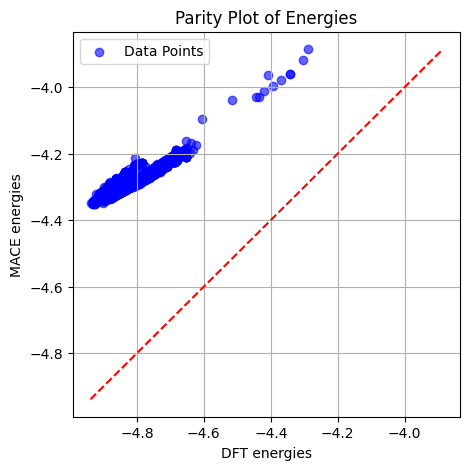

In [ ]:
# Create the parity plot
plt.figure(figsize=(5,5))

plt.scatter(dft_energies_form, mace_energies_form, color='blue', alpha=0.6, label="Data Points")

# Plot the y = x reference line
min_val = min(np.min(dft_energies_form), np.min(mace_energies_form))
max_val = max(np.max(dft_energies_form), np.max(mace_energies_form))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Labels and title
plt.xlabel("DFT energies")
plt.ylabel("MACE energies")
plt.title("Parity Plot of Energies")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Residual Plot of Energies

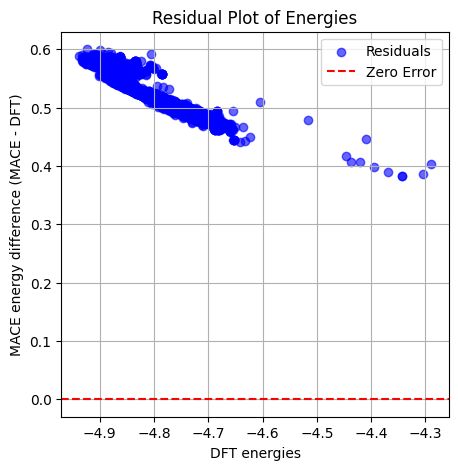

In [ ]:
plt.figure(figsize=(5,5))
residuals = mace_energies_form - dft_energies_form
plt.scatter(dft_energies_form, residuals, color='blue', alpha=0.6, label="Residuals")

plt.axhline(0, color='red', linestyle='--', label="Zero Error")

plt.xlabel("DFT energies")
plt.ylabel("MACE energy difference (MACE - DFT)")
plt.title("Residual Plot of Energies")
plt.legend()
plt.grid(True)

plt.show()

## mace-mpa-0-medium.model - dispersion

In [26]:
ase_structure = Atoms(['S'],[[0.0, 0.0, 0.0]])
sp_mace = SinglePoint(
    struct=ase_structure.copy(),
    arch="mace_mp",
    device="cpu",
    model_path="/Users/brunocamino/Desktop/UCL/mace_benchmark/models/mace-mpa-0-medium.model",
    calc_kwargs={"default_dtype": "float64","dispersion":True},
    properties="energy",
)

init_energy = sp_mace.run()["energy"]
print(init_energy)

Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
Using TorchDFTD3Calculator for D3 dispersion corrections
-0.89160769


In [ ]:
li_dft_energy = -7.4535580426043E+00*HARTREE_TO_EV
ti_dft_energy = -8.4917384909564E+02*HARTREE_TO_EV
s_dft_energy = -3.9804168854419E+02*HARTREE_TO_EV

li_mace_energy = -0.29754725
ti_mace_energy = -2.50054871
s_mace_energy = -0.89160769


In [27]:
energies = np.loadtxt("data/lts/pt_model/d3/all_energies_d3.csv", delimiter=",", skiprows=1)

num_sites = 72

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column

dft_energies_form = (dft_energies - (li_dft_energy*18 + 
                                    ti_dft_energy*9 + s_dft_energy*27))/num_sites

mace_energies_form = (mace_energies - (li_mace_energy*18 + 
                                    ti_mace_energy*9 + s_mace_energy*27))/num_sites

keep_indices = np.where(dft_energies_form > -6)[0]

dft_energies_form = dft_energies_form[keep_indices]
mace_energies_form = mace_energies_form[keep_indices]

In [28]:
get_errors(dft_energies_form,mace_energies_form)


MSE: 1.371e-02
RMSE: 1.171e-01
Percentage MSE: 1.076e-01 %
Max Absolute Error: 2.546e-01
Max Percentage Error: 7.063e+00 %


In [29]:
get_rankings(dft_energies_form,mace_energies_form)

Spearman's Rank Correlation: 0.93017
Kendall's Tau: 0.83664


### Parity plot

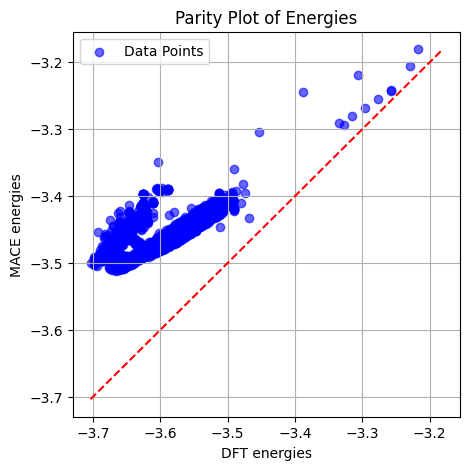

In [30]:
# Create the parity plot
plt.figure(figsize=(5,5))

plt.scatter(dft_energies_form, mace_energies_form, color='blue', alpha=0.6, label="Data Points")

# Plot the y = x reference line
min_val = min(np.min(dft_energies_form), np.min(mace_energies_form))
max_val = max(np.max(dft_energies_form), np.max(mace_energies_form))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Labels and title
plt.xlabel("DFT energies")
plt.ylabel("MACE energies")
plt.title("Parity Plot of Energies")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Residual Plot of Energies

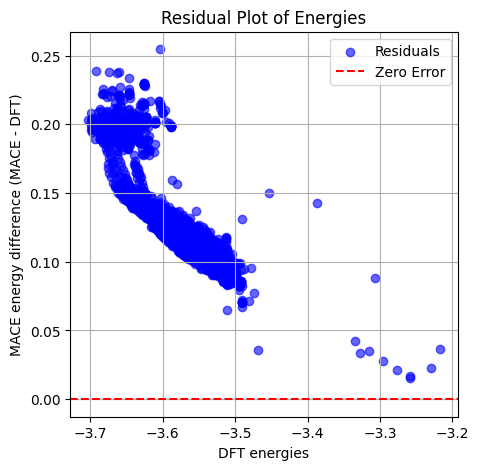

In [31]:
plt.figure(figsize=(5,5))
residuals = mace_energies_form - dft_energies_form
plt.scatter(dft_energies_form, residuals, color='blue', alpha=0.6, label="Residuals")

plt.axhline(0, color='red', linestyle='--', label="Zero Error")

plt.xlabel("DFT energies")
plt.ylabel("MACE energy difference (MACE - DFT)")
plt.title("Residual Plot of Energies")
plt.legend()
plt.grid(True)

plt.show()

In [ ]:
residuals = mace_energies_form - dft_energies_form
np.mean(residuals)

0.5010544575923563

In [ ]:
np.mean(mace_energies_form)

-4.2580053746024715

In [ ]:
all_structures = read('data/crystal/lts/concatenated_files/lts_all.xyz',":")

In [ ]:
view(all_structures[6398])

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/mace-tes...>

In [ ]:
np.where(dft_energies_form > -6)[0]

array([    0,     1,     2, ..., 24029, 24030, 24031])

In [ ]:
len(dft_energies_form)

24032

### Errors

In [ ]:
np.sort(dft_energies)

array([-754067.3855685, -742760.6010391, -742685.5482815, ...,
       -504294.3297341, -504292.2282146, -504291.3880448])

In [ ]:
ase_structure = Atoms(['S'],[[0.0, 0.0, 0.0]])
sp_mace = SinglePoint(
    struct=ase_structure.copy(),
    arch="mace_mp",
    device="cpu",
    model_path="/Users/brunocamino/Desktop/UCL/mace_benchmark/models/mace-mpa-0-medium.model",
    calc_kwargs={"default_dtype": "float64","dispersion":True},
    properties="energy",
)

init_energy = sp_mace.run()["energy"]
print(init_energy)

Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.
-0.89160769


In [7]:
li_dft_energy = -7.4535580426043E+00*HARTREE_TO_EV
ti_dft_energy = -8.4917384909564E+02*HARTREE_TO_EV
s_dft_energy = -3.9804168854419E+02*HARTREE_TO_EV

li_mace_energy = -0.29754725
ti_mace_energy = -2.50054871
s_mace_energy = -0.89160769


In [24]:
energies = np.loadtxt("data/lts/pt_model/all_energies.csv", delimiter=",", skiprows=1)

num_sites = 72

# Extract the two columns separately
dft_energies = energies[:, 0]  # First column
mace_energies = energies[:, 1]  # Second column

dft_energies_form = (dft_energies - (li_dft_energy*18 + 
                                    ti_dft_energy*9 + s_dft_energy*27))/num_sites

mace_energies_form = (mace_energies - (li_mace_energy*18 + 
                                    ti_mace_energy*9 + s_mace_energy*27))/num_sites

keep_indices = np.where(dft_energies_form > -6)[0]

dft_energies_form = dft_energies_form[keep_indices]
mace_energies_form = mace_energies_form[keep_indices]

In [25]:
np.sort(dft_energies_form)

array([-3.70384493, -3.69935029, -3.69919882, ..., -3.25800319,
       -3.22881542, -3.21714639])

In [9]:
get_errors(dft_energies_form,mace_energies_form)


MSE: 2.514e-01
RMSE: 5.014e-01
Percentage MSE: 1.110e+00 %
Max Absolute Error: 6.001e-01
Max Percentage Error: 1.230e+01 %


In [10]:
get_rankings(dft_energies_form,mace_energies_form)

Spearman's Rank Correlation: 0.98491
Kendall's Tau: 0.91303


### Parity plot

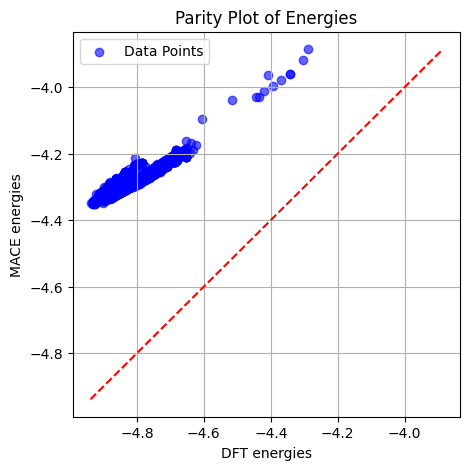

In [19]:
# Create the parity plot
plt.figure(figsize=(5,5))

plt.scatter(dft_energies_form, mace_energies_form, color='blue', alpha=0.6, label="Data Points")

# Plot the y = x reference line
min_val = min(np.min(dft_energies_form), np.min(mace_energies_form))
max_val = max(np.max(dft_energies_form), np.max(mace_energies_form))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

# Labels and title
plt.xlabel("DFT energies")
plt.ylabel("MACE energies")
plt.title("Parity Plot of Energies")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Residual Plot of Energies

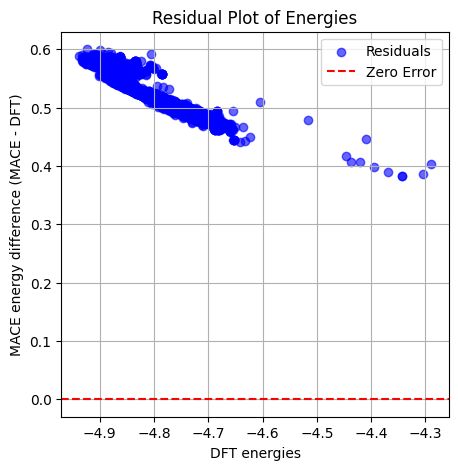

In [21]:
plt.figure(figsize=(5,5))
residuals = mace_energies_form - dft_energies_form
plt.scatter(dft_energies_form, residuals, color='blue', alpha=0.6, label="Residuals")

plt.axhline(0, color='red', linestyle='--', label="Zero Error")

plt.xlabel("DFT energies")
plt.ylabel("MACE energy difference (MACE - DFT)")
plt.title("Residual Plot of Energies")
plt.legend()
plt.grid(True)

plt.show()

In [17]:
residuals = mace_energies_form - dft_energies_form
np.mean(residuals)

0.5010544575923563

In [16]:
np.mean(mace_energies_form)

-4.2580053746024715

In [49]:
all_structures = read('data/crystal/lts/concatenated_files/lts_all.xyz',":")

In [54]:
view(all_structures[6398])

<Popen: returncode: None args: ['/Users/brunocamino/miniconda3/envs/mace-tes...>

In [86]:
np.where(dft_energies_form > -6)[0]

array([    0,     1,     2, ..., 24029, 24030, 24031])

In [65]:
len(dft_energies_form)

24032

### Errors

In [72]:
np.sort(dft_energies)

array([-754067.3855685, -742760.6010391, -742685.5482815, ...,
       -504294.3297341, -504292.2282146, -504291.3880448])